In [17]:
from os import listdir
import numpy as np
import pandas as pd
#pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, cm, ticker
from matplotlib.mlab import griddata
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [10]:
def CreateMasterSpiralDF(dirName="."):
    """CreateMasterSpiralDF(dirName) where dirName is the directory name of the .spiral files,
       output pandas dataframe of all spiral files header data and filenames"""
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-7:] == '.spiral']
    
    if len(fileNames)==0:
        print("No '.spiral' files found in directory '"+dirName+"'.")
        return
    
    D = {"file_name" : []}
    for index,name in enumerate(fileNames):
        f = open(name,'r')
        for i in range(2): colNames = f.readline().split()
        if index == 0:
            for colName in colNames:
                D[colName] = []
        D["file_name"].append(name)
        simParams = f.readline().split()
        for colIndex,colName in enumerate(colNames):
            D[colName].append(float(simParams[colIndex]))
        f.close()
    df = pd.DataFrame(D)
    return df

def CreateSpiralDF(fileName):
    """CreateSpiralDF(fileName) where fileName is the name of a '.spiral' analysis file,
       outputs pandas dataframe of time series data"""
    assert isinstance(fileName,str), "The 'fileName' argument must be a string!"
    try:
        f = open(fileName,'r')
    except:
        print("Could not open file '" + fileName + "'.")
        return
    for i in range(4): colNames = f.readline().split()
    D = {}
    for colName in colNames:
        D[colName] = []
    for line in f:
        line = line.split()
        if (len(line) != len(colNames)):
            break # early exit due to early simulation termination
        for colIndex, colName in enumerate(colNames):
            D[colName].append(float(line[colIndex]))
    f.close()
    df = pd.DataFrame(D)
    return df

def GetSpiralFrequencies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    freqs = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        if not (df["time"].iloc[-1] < maxTime):
            freqs[i] = GetSpiralFrequency(df,maxTime)
    masterDF["spiral_frequency"] = freqs
    
def GetBendingEnergies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    ebend = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        if not (df["time"].iloc[-1] < maxTime) and masterDF.iloc[i]["spiral_frequency"]:
            ebend[i] = df["E_bend"].iloc[-1]
        else:
            ebend[i] = None
    masterDF["E_bend"] = ebend

def GetSpiralFrequency(df,maxTime):
    assert isinstance(df,pd.DataFrame),"df needs to be pandas DataFrame type"
    N=int(len(df["time"])/2) #num of gridpoints
    delta=1
    time = np.array(df["time"][:N])
    z = np.array(df["tip_z_proj"][N:])
    # If we have odd time, make z and time same size
    if len(time)!=len(z):
        z = np.array(df["tip_z_proj"][N+1:])
    # Zero pad data, assuming spiral continues indefinitely
    padding=int(2**17)
    yf=np.fft.fft(z,n=padding)
    xf=np.fft.fftfreq(padding,d=delta)
    freq = xf[int(np.argmax(2.0/padding * np.abs(yf[0:int(padding/2)])))]
    # If our period lasts longer than a simulation, then return freq=0 (assume no spiral) 
    if freq > 3.0/maxTime:
        return freq
    else:
        return 0

def GetSpiralNumbers(masterDF):
    snums = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        maxTime = masterDF.iloc[i].nsteps/masterDF.iloc[i].nspec - 1
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        if not (df["time"].iloc[-1] < maxTime):
            snums[i] = GetSpiralNumber(df,maxTime)
    masterDF["spiral_numbers"] = snums
    
def GetSpiralNumber(df,maxTime):
    if len(df.time) < maxTime:
        return 0
    N = int(len(df.time)/2)
    snum = np.median(df.spiral_number[N:])
    return snum
    
def PlotSpiralFrequencies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        # If we exited early, spiral did not form
        if not (df["time"].iloc[-1] < maxTime):
            PlotSpiralFrequency(df,maxTime)

def PlotSpiralFrequency(df,maxTime):
    assert isinstance(df,pd.DataFrame),"df needs to be pandas DataFrame type"
    assert isinstance(maxTime, (float,int)), "maxTime needs to be a float or int"
    N=len(df["time"])/2 #num of gridpoints
    delta=1
    time = np.array(df["time"][:N])
    z = np.array(df["tip_z_proj"][N:])
    # If we have odd time, make z and time same size
    if len(time)!=len(z):
        z = np.array(df["tip_z_proj"][N+1:])
    # Zero pad data, assuming spiral continues indefinitely
    padding=int(2**17)
    yf=np.fft.fft(z,n=padding)
    xf=np.fft.fftfreq(padding,d=delta)
    freq = xf[int(np.argmax(2.0/padding * np.abs(yf[0:padding/2])))]
    if freq < 1.0/maxTime:
        return
    guess_phase=0
    optimize_func = lambda phase: np.sin(2*np.pi*freq*(time+phase))-z
    est_phase = leastsq(optimize_func, guess_phase)[0]
    est_data = np.sin(2*np.pi*freq*(time+est_phase))
    f, ax = plt.subplots(2)
    ax[0].set_title(r"$f_{max} = $" + str(freq))
    ax[0].plot(xf,yf.real,xf,yf.imag)
    ax[0].set_xlim(0,2*freq)
    ax[0].set_xlabel("frequency")
    ax[0].set_ylabel("fft signal")
    ax[0].legend(["real","imag"],loc=1)
    ax[1].plot(time,z,'k-',time,est_data,'r--')
    ax[1].set_xlabel("sim time")
    ax[1].set_title("Filament tip orientation "+r'$U_Z$')
    ax[1].set_ylabel(r'$U_Z$')
    ax[1].set_xlim(0,min(8.0/freq,time[-1]))
    ax[1].legend(['Data','LS Fit'],loc=1)
    f.subplots_adjust(hspace=0.7)
    plt.show()
    plt.close()
    
def PlotFrequencyContour(masterDF):
    df=masterDF
    x1 = np.linspace(df['driving'].min(), df['driving'].max(), len(df['driving'].unique()))
    y1 = np.linspace(df['persistence_length'].min(), df['persistence_length'].max(), len(df['persistence_length'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    # Interpolate unstructured D-dimensional data.
    z2 = griddata((df['driving'], df['persistence_length']), df['spiral_frequency'], (x2, y2),method='linear')
    fig = plt.figure()
    ax = fig.gca()
    surf = ax.contourf(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Spiral frequency, L=50')
    plt.xlabel("Driving")
    plt.ylabel("Persistence Length")
    plt.ylim(0,8000)
    plt.show()
    plt.close()
    
def PlotEnergyContour(masterDF):
    df=masterDF
    x1 = np.linspace(df['driving'].min(), df['driving'].max(), len(df['driving'].unique()))
    y1 = np.linspace(df['persistence_length'].min(), df['persistence_length'].max(), len(df['persistence_length'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    # Interpolate unstructured D-dimensional data.
    z2 = griddata((df['driving'], df['persistence_length']), df['E_bend'], (x2, y2),method='linear')
    fig = plt.figure()
    ax = fig.gca()
    surf = ax.contourf(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Bending Energy, L=50')
    plt.xlabel("Driving")
    plt.ylabel("Persistence Length")
    plt.ylim(0,8000)
    plt.show()
    plt.close()

def GetSpiralBool(masterDF):
    spirals = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        if masterDF.iloc[i]["spiral_frequency"] > 0:
            spirals[i] = 1
    masterDF["spiral"] = spirals

In [ ]:
spiral_params=pd.read_csv('spiral_data_l050_v289_filament.spiral',skiprows=1,nrows=1,delim_whitespace=True)
spiral_data=pd.read_csv('spiral_data_l050_v289_filament.spiral',skiprows=3,delim_whitespace=True)

In [6]:
df=CreateMasterSpiralDF('spiral_data_l050')

In [11]:
GetSpiralNumbers(df)

In [13]:
df['spiral_number']=df.spiral_frequency

In [14]:
df=df.drop('spiral_frequency',axis=1)

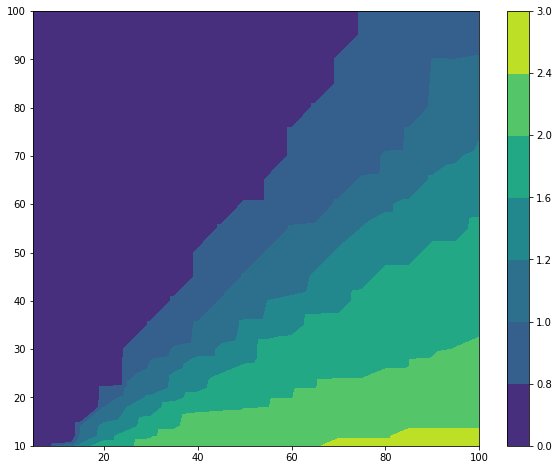

In [110]:
X=df.driving
Y=df.persistence_length/df.length
Z=df.spiral_number
#Xi,Yi = np.meshgrid(X, Y)
#Zi = griddata(X,Y,Z,Xi,Yi)
fig,ax=plt.subplots(figsize=(10,8))
cax = ax.tricontourf(X, Y, Z, levels=[0,0.8,1,1.2,1.6,2.0,2.4,3.0], alpha=1 )#cmap = cm.viridis)
fig.colorbar(cax)
#plt.clabel(cax,inline=1,fmt='%1.1f')
plt.show()

In [83]:
df_low = df[df.spiral_number < 0.8]

In [84]:
df_low.spiral_number.unique()

array([0.])

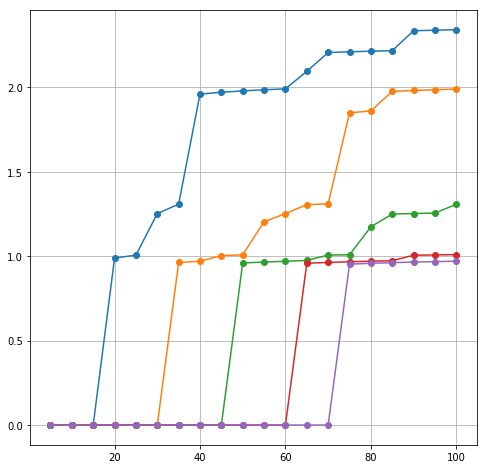

In [131]:
fig,ax = plt.subplots(figsize=(8,8))
groups = df.groupby('persistence_length')
for key,group in groups:
    if (key/50)%20==0:
        ax.plot(group.driving,group.spiral_number,label=key,linestyle='-',marker='o')
#plt.colorbar()
ax.grid(True)
fig.canvas.draw()